# Logistic Regression Using Optim.jl

## Logistic Regression

A major focus in Machine Learning is classification problem where we want to predict which category a certain object belongs to. For example, we might be interested whether an email is spam or not, which number does a picture show, whether a credit card holder will default or not, etc.

For the credit card case, the intuition is that we want to know the probability that card holder $i$ will default, namely $\pi_{i}$, based on account balance, income, etc. The more certain we are, the closer the output is to 1. If we use Linear Regression, $\pi_{i}$ may be lager than 1, which is certainly not true. Logistic Regression is introduced to solve such issue which has the form

$$
\pi_{i} = \frac{e^{\beta_0+\beta_1x_{1i}+\beta_2x_{2i}}}{1+e^{\beta_0+\beta_1x_{1i}+\beta_2x_{2i}}}
$$

The function has an "S" shape ranging from 0 to 1 as shown below.

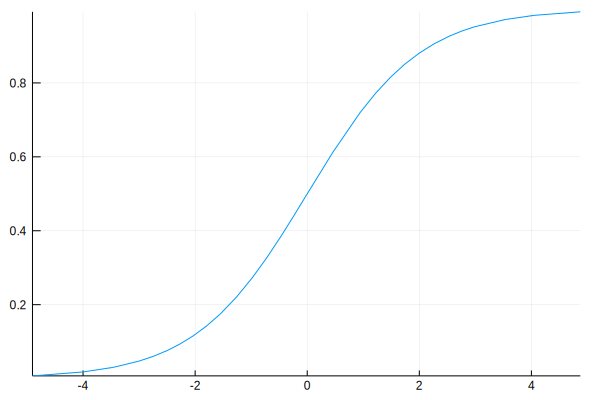

In [1]:
# in case you hadn't installed the package
# Pkg.update()
# Pkg.add("Plots")
using Plots; gr()
plot(x->e^x/(1+e^x), legend=false)

In vector form, the function becomes 

$$
\pi_{i} = \frac{e^{\mathbf{x_i}^T\beta}}{1+e^{\mathbf{x_i}^T\beta}} = \frac{1}{1+e^{-\mathbf{x_i}^T\beta}}
$$

where

$$
\mathbf{x_i} = \begin{bmatrix}
       1    \\
       x_{1i} \\
       x_{2i} \\ 
      \end{bmatrix}
\quad \beta = \begin{bmatrix}
               \beta_0 \\
               \beta_1 \\
               \beta_2 \\ 
              \end{bmatrix}
$$

## Maximum Likelihood Estimation

We use maximum likelihood estimation to estimate the parameters ($\beta$), we need find the parameters that maximize the likelihood function given the data we have. Assuming the sample size is $n$ and the data is i.i.d, the likelihood function is

$$
\begin{align*}
p\left(y, \mathbf{X}  \mid  \beta \right) &=\prod_{i:y=1}\pi_{i}\prod_{i:y=o}(1-\pi_{i})\\
                                          &=\prod_{i=1}^{n}\pi_{i}^{y_{i}}(1-\pi_{i})^{1-y_{i}}\\
\end{align*}
$$

Therefore the log likelihood function is

$$
\begin{align*} 
\ell(\beta)&=\sum_{i=1}^{n}[y_{i}\log(\pi_{i})+(1-y_{i})\log(1-\pi_{i})]\\ 
& = \sum_{i=1}^{n}[y_{i}\mathbf{x_i}^T\beta - \log(1+e^{\mathbf{x_i}^T\beta})]
\end{align*}
$$

Because `Optim.jl` is used to **minimize** a function, the objective function becomes **negative** log likelihood function.

$$
\underset{\beta}{\text{minimize}} \quad f(\beta) = -\ell(\beta) = \sum_{i=1}^{n}[\log(1+e^{\mathbf{x_i}^T\beta}) - y_{i}\mathbf{x_i}^T\beta]
$$

To transform the objective function into code, note that `X` is $n$ rows of $\mathbf{x_i}^T$ and operators with dot(.) are element-wise.

$$
\texttt{X} = \begin{bmatrix}
        1      & x_{11} & x_{21} \\
        1      & x_{12} & x_{22} \\
        \vdots & \vdots & \vdots\\
        1      & x_{1n} & x_{2n} \\ 
        \end{bmatrix}
$$

$$
\texttt{X*β} = \begin{bmatrix}
        \beta_0 + \beta_1 x_{11} + \beta_2 x_{21} \\
        \vdots \\
        \beta_0 + \beta_1 x_{1n} + \beta_2 x_{2n} \\ 
        \end{bmatrix}
$$

In [2]:
f(β) = sum(log.(1 .+ e.^(X * β)) - y .* (X * β))

f (generic function with 1 method)

## Performing Regression
We are now performing Logistic Regression on the credit card data from ["An Introduction to Statistical Learning with Applications in R"](http://www-bcf.usc.edu/~gareth/ISL/data.html). For this example, we are only interested in the effects of `Balance` as $x_1$ and `Income` as $x_2$. First let's prepare our data.

In [3]:
# Pkg.add("RDatasets")
using RDatasets
credit = dataset("ISLR", "Default")
credit[1] = recode(credit[1], "Yes"=>1, "No"=>0) # recode categorical data into number 1 or 0
head(credit)

,Default,Student,Balance,Income
1,0,No,729.526,44361.6
2,0,Yes,817.18,12106.1
3,0,No,1073.55,31767.1
4,0,No,529.251,35704.5
5,0,No,785.656,38463.5
6,0,Yes,919.589,7491.56


In [4]:
X = hcat(ones(Int8, size(credit)[1]), credit[3], credit[4]) # add 1 as the first column
y = Array(credit[1]) # convert into Array type

10000-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Gradient Free Methods
Now we can use `Optim.jl` to estimate $\beta$. Note that we need pass an array of initial values of `β`. In the example the initial value is `[0.0,0.0,0.0]`. If we don't pass the gradient function, `Optim.jl` will use methods that don't require gradient infomation. The default method is Nelder-Mead.

In [5]:
#Pkg.add("Optim")
using Optim

In [6]:
optimize(f, zeros(3)) # equal to optimize(f, zeros(3), NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.540474285836979,0.005647107711267278, ...]
 * Minimum: 7.894831e+02
 * Iterations: 178
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 327

Another gradient free method is Simulated Annealing, though it doesn't seem to work well in this example.

In [7]:
optimize(f, zeros(3), SimulatedAnnealing())

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.0,0.0,0.0]
 * Minimum: 6.931472e+03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = NaN 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = NaN |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = NaN 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001

If no gradient function is passed, `Optim.jl` will provide an approximate gradient and apply gradient required method.

In [8]:
optimize(f, zeros(3), LBFGS()) 

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.495346939483449,0.005638072208404706, ...]
 * Minimum: 7.895012e+02
 * Iterations: 20
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.12e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.91e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.50e-03 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 144
 * Gradient Calls: 144

### Gradient Required methods
We can move to gradient required methods by providing gradient information.

$$
\nabla f(\beta) = \begin{bmatrix}
           \frac{\partial f}{\partial \beta_0}   \\
           \frac{\partial f}{\partial \beta_1} \\
           \frac{\partial f}{\partial \beta_2} \\ 
           \end{bmatrix}
         = \begin{bmatrix}
           \sum_{i=1}^{n} e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_i \\
           \sum_{i=1}^{n} x_{1i}e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_ix_{1i}      \\
           \sum_{i=1}^{n} x_{2i}e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_ix_{2i}      \\ 
           \end{bmatrix}
         = \begin{bmatrix}
           \sum_{i=1}^{n} (1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_i \\
           \sum_{i=1}^{n} x_{1i}(1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_ix_{1i}      \\
           \sum_{i=1}^{n} x_{2i}(1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_ix_{2i}      \\ 
           \end{bmatrix}
$$

We put exclamation mark(!) at the end of the function name because we make modifications on the `storage` vector variable, or you can call it `gradient` variable. After each iteration, the `storage` variable will change as the value of `β` changes, we only need transform each entry of $\nabla f(\beta)$ into code. 

In [9]:
function g!(storage, β)
    storage[1]= sum((1 .+ e.^(-X * β)).^-1 - y)
    storage[2]= sum(X[:,2]./(1 .+ e.^(-X * β)) - y.*X[:,2])
    storage[3]= sum(X[:,3]./(1 .+ e.^(-X * β)) - y.*X[:,3])
end

g! (generic function with 1 method)

The default method is L-BFGS which is limited memory version of BFGS.

In [10]:
optimize(f, g!, zeros(3))  # equal to optimize(f, g!, zeros(3), LBFGS())

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.540468449934565,0.005647102950316482, ...]
 * Minimum: 7.894831e+02
 * Iterations: 20
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.45e-10 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.43e-08 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 145
 * Gradient Calls: 145

The BFGS method uses gradient to approxiamate the Hessian and apply Newton's method.

In [11]:
optimize(f, g!, zeros(3), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.540468419741224,0.005647102938940267, ...]
 * Minimum: 7.894831e+02
 * Iterations: 15
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.02e-08 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.44e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.44e-06 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 114
 * Gradient Calls: 114

`Optim.jl` can also apply Gradient Descent method and Conjugate Gradient Descent method.

In [12]:
optimize(f, g!, zeros(3), GradientDescent())

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-4.491384964357726e-6,0.00040759649811412105, ...]
 * Minimum: 1.734554e+03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.57e-09 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 4.08e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.39e+02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2587
 * Gradient Calls: 2587

In [13]:
optimize(f, g!, zeros(3), ConjugateGradient())

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-12.38365166873607,0.006045298971043064, ...]
 * Minimum: 7.912599e+02
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.28e-06 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 8.44e-09 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 8.82e+02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2137
 * Gradient Calls: 1247

### Hessian Required Methods

`Optim.jl` can apply Newton's method if we provide the Hessian. This method is the gold standard of unconstrained smooth optimization, though it could be painful to calculate the Hessian.

$$
\mathbf{H}f(\beta) = \begin{bmatrix}
              \frac{\partial}{\partial \beta_0}   \\
              \frac{\partial}{\partial \beta_1} \\
              \frac{\partial}{\partial \beta_2} \\ 
              \end{bmatrix}
              \begin{bmatrix} 
              \frac{\partial f}{\partial \beta_0} \ \frac{\partial f}{\partial \beta_1} \ \frac{\partial f}{\partial \beta_2}
              \end{bmatrix}
            = \begin{bmatrix}
              \frac{\partial^2 f}{\partial \beta_0^2} \ \frac{\partial^2 f}{\partial \beta_0\beta_1} \ \frac{\partial^2 f}{\partial \beta_0\beta_2}\\
              \frac{\partial^2 f}{\partial \beta_0\beta_1} \ \frac{\partial^2 f}{\partial \beta_1^2} \ \frac{\partial^2 f}{\partial \beta_1\beta_2}\\
              \frac{\partial^2 f}{\partial \beta_0\beta_2} \ \frac{\partial^2 f}{\partial \beta_1\beta_2} \ \frac{\partial^2 f}{\partial \beta_2^2} \\ 
              \end{bmatrix}
            = \begin{bmatrix}
              \sum_{i=1}^{n}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} & 
              \sum_{i=1}^{n}x_{1i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} & 
              \sum_{i=1}^{n}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} \\
              \sum_{i=1}^{n}x_{1i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}         & 
              \sum_{i=1}^{n}x_{1i}^2e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}       &
              \sum_{i=1}^{n}x_{1i}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}   \\
              \sum_{i=1}^{n}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}         &
              \sum_{i=1}^{n}x_{1i}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}   & 
              \sum_{i=1}^{n}x_{2i}^2e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}       \\ 
              \end{bmatrix}
$$

In [14]:
function h!(storage, β)
    storage[1,1]= sum(e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[1,2]= sum(X[:,2] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[1,3]= sum(X[:,3] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[2,2]= sum(X[:,2].^2 .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[2,3]= sum(X[:,2] .* X[:,3] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[3,3]= sum(X[:,3].^2 .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
end

h! (generic function with 1 method)

In [15]:
optimize(f, g!, h!, zeros(3)) # equal to optimize(f, g!, h!, zeros(3), Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.540468994905527,0.005647103239234815, ...]
 * Minimum: 7.894831e+02
 * Iterations: 274
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 8.42e-08 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.37e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 789
 * Gradient Calls: 789
 * Hessian Calls: 274

If we put some restrictions on Newton's Method, such method is called Newton's Method With a Trust Region.

In [16]:
optimize(f, g!, h!, zeros(3), NewtonTrustRegion())

Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.54046844993458,0.0056471029503164915, ...]
 * Minimum: 7.894831e+02
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 6.78e-21 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.04e-09 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001
 * Gradient Calls: 1001
 * Hessian Calls: 1001

## Obtaining Results
After applying the optimization algorithm, we can retrieve our results($\beta$) by following steps. Since some functions are not exported, they have to be prefixed by `Optim.`.

In [17]:
results = optimize(f, g!, h!, zeros(3))
estimate_β = Optim.minimizer(results)

3-element Array{Float64,1}:
 -11.5405   
   0.0056471
   2.0809e-5